<a href="https://colab.research.google.com/github/alicezil/38615-Lab-2/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#38615 Lab 2: Clustering

Tasks:
1. Load the data and explore it.
2. Perform k-means clustering. Determine the optimal number of clusters using e.g. elbow method.
3. Perform clustering with different clustering methods implemented in Scikit Learn.
4. Now, try clustering with another distance metric (e.g. Cosine, Jaccard, etc). Hint: Think whether the default distance metric is appropriate for your data or not.
5. Visualize results using the dimensionality reduction (UMAP or tSNE) technique with respect to the cluster labels.
6. Compare clustering results. Try to rationalize observed commonalities or differences with respect to clustering methods and distance metrics.

#1. Loading the Data and Exploring It

**1.1 Importing the necessary libraries**

In [22]:
%pip install --upgrade kneed

import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import kneed

from sklearn import manifold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
from kneed import KneeLocator

%matplotlib inline 
sns.set(color_codes=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**1.2 Loading the data into the dataframe and complete basic data preparation**

In [2]:
df = pd.read_csv("/content/Lab2_clustering_dataset.csv")
df.shape

(969, 1025)

In [3]:
df_summary = df.describe(include='all')
df_summary.head(8) 

,ID,D_0,D_1,D_2,D_3,D_4,D_5,D_6,D_7,D_8,...,D_1014,D_1015,D_1016,D_1017,D_1018,D_1019,D_1020,D_1021,D_1022,D_1023
count,969,969.0,969.000000,969.0,969.0,969.000000,969.0,969.000000,969.00000,969.000000,...,969.000000,969.000000,969.0,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000
unique,969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,AAEAMMIUQZAASJ-MRXNPFEDSA-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.0,0.900929,1.0,1.0,0.684211,1.0,0.764706,0.68937,0.570691,...,0.860681,0.737874,1.0,0.881321,0.854489,0.681115,0.553148,0.809082,0.821465,0.912281
std,NaN,0.0,0.298912,0.0,0.0,0.465070,0.0,0.424402,0.46299,0.495233,...,0.346458,0.440018,0.0,0.323577,0.352797,0.466285,0.497424,0.393228,0.383160,0.283032
min,NaN,1.0,0.000000,1.0,1.0,0.000000,1.0,0.000000,0.00000,0.000000,...,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,1.0,1.000000,1.0,1.0,0.000000,1.0,1.000000,0.00000,0.000000,...,1.000000,0.000000,1.0,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000


In [4]:
# removing duplicate rows if there are any
df = df.drop_duplicates()    

# dropping the missing values
df = df.dropna()

# dropping the first column since it is simply a different value for each row
# and therefore not useful for data analysis

df = df.drop(['ID'], axis=1)

df.shape

(969, 1024)

As we can see above there were no duplicates or missing values. Let's take a look at the summary table to get a better sense of the data.

In [5]:
df_summary = df.describe()
df_summary.head(8) 

,D_0,D_1,D_2,D_3,D_4,D_5,D_6,D_7,D_8,D_9,...,D_1014,D_1015,D_1016,D_1017,D_1018,D_1019,D_1020,D_1021,D_1022,D_1023
count,969.0,969.000000,969.0,969.0,969.000000,969.0,969.000000,969.00000,969.000000,969.000000,...,969.000000,969.000000,969.0,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000
mean,1.0,0.900929,1.0,1.0,0.684211,1.0,0.764706,0.68937,0.570691,0.373581,...,0.860681,0.737874,1.0,0.881321,0.854489,0.681115,0.553148,0.809082,0.821465,0.912281
std,0.0,0.298912,0.0,0.0,0.465070,0.0,0.424402,0.46299,0.495233,0.484004,...,0.346458,0.440018,0.0,0.323577,0.352797,0.466285,0.497424,0.393228,0.383160,0.283032
min,1.0,0.000000,1.0,1.0,0.000000,1.0,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,1.000000,1.0,1.0,0.000000,1.0,1.000000,0.00000,0.000000,0.000000,...,1.000000,0.000000,1.0,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
50%,1.0,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.00000,1.000000,0.000000,...,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.0,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.00000,1.000000,1.000000,...,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.0,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.00000,1.000000,1.000000,...,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


There are multiple columns where the standard deviation is 0 implying that the entire column has the same value (in this case 1.0). These columns are entirely uhelpful in our data analysis and therefore can be eliminated. Let's do so:

In [6]:
#removing the columns that contain the same value in every row
for col in df_summary:
    if df_summary[col]['std'] == 0:
      df = df.drop([col],axis=1)

df.shape

(969, 950)

Next let's construct a correlation matrix and remove highly correlated variables:

In [7]:
#create correlation matrix
corr_matrix = df.corr().abs()

#isolate upper triangle (for lack of repetition)
upper_triangle = corr_matrix.where((np.triu(np.ones(corr_matrix.shape), k=1) + 
                           np.tril(np.ones(corr_matrix.shape), k=-1)).astype(bool))

#make a list of columns with correlation larger than .95
drop_list = []
for col in upper_triangle.columns:
  if any(upper_triangle[col] > 0.95):
    drop_list.append(col)

#drop all the columns from the list
df.drop(drop_list, axis=1, inplace=True)

df.shape

(969, 912)

POSSIBLY INSERT CODE THAT CHECKS IF ANY MAXES ARE OVER 1 AND ANY MINS ARE UNDER 0 Since none of the maxes are over 1 and none of the mins are under 0 we do not have to scale our data before clustering.

**1.3 Dimensionality reduction using PCA**

In [8]:
#applying PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df)

Now let's make a PCA plot and take a look at our data without using any clustering methods

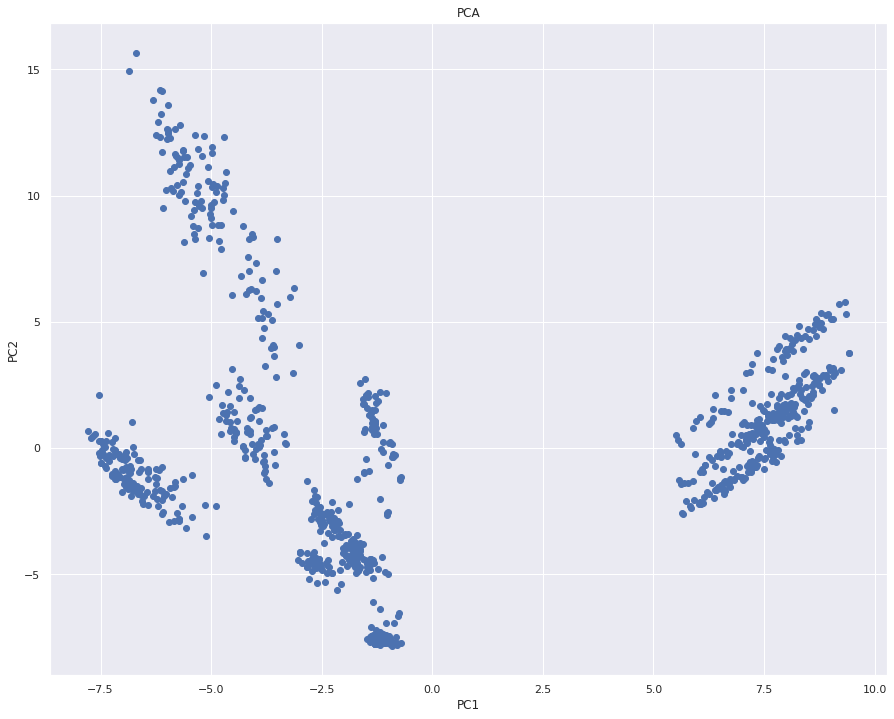

In [9]:
#plotting PCA
plt.rcParams['figure.figsize'] = [15, 12]
plt.scatter(principalComponents[:,0], principalComponents[:,1])
plt.title('PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

#2. Determining Optimal Number of Clusters

**2.1 Constructing a list of sum of squared distances for different number of clusters (from 1 to 15)**

In [10]:
#constructing the list without dimensionality reduction
sse_list = []
for num in range(1,16):
    km = KMeans(n_clusters=num)
    km = km.fit(df)
    sse_list.append(km.inertia_)

In [11]:
#constructing the list with dimensionality reduction
sse_list_reduced = []
for num in range(1,16):
    km = KMeans(n_clusters=num)
    km = km.fit(principalComponents)
    sse_list_reduced.append(km.inertia_)

**2.2 Plotting the sum of squared distances vs number of clusters**

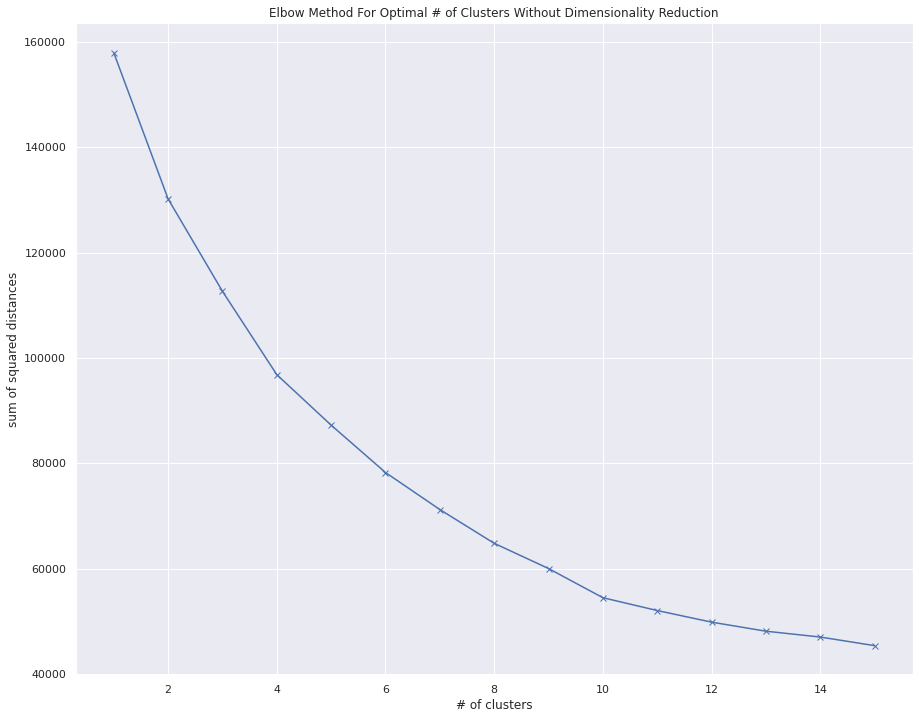

In [12]:
#plotting without dimensionality reduction
plt.plot(range(1, 16), sse_list, 'bx-')
plt.xlabel('# of clusters')
plt.ylabel('sum of squared distances')
plt.title('Elbow Method For Optimal # of Clusters Without Dimensionality Reduction')
plt.show()

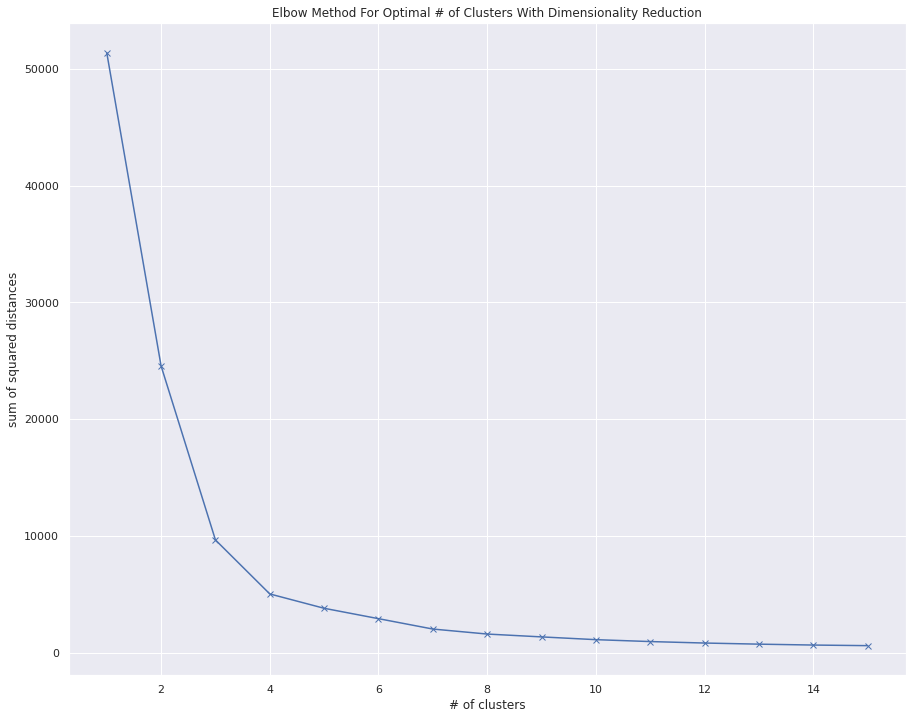

In [13]:
#plotting with dimensionality reduction
plt.plot(range(1, 16), sse_list_reduced, 'bx-')
plt.xlabel('# of clusters')
plt.ylabel('sum of squared distances')
plt.title('Elbow Method For Optimal # of Clusters With Dimensionality Reduction')
plt.show()

**2.3 Finding the "elbow" of the graph** (via code because quite honestly I am always unsure when I do it by hand)

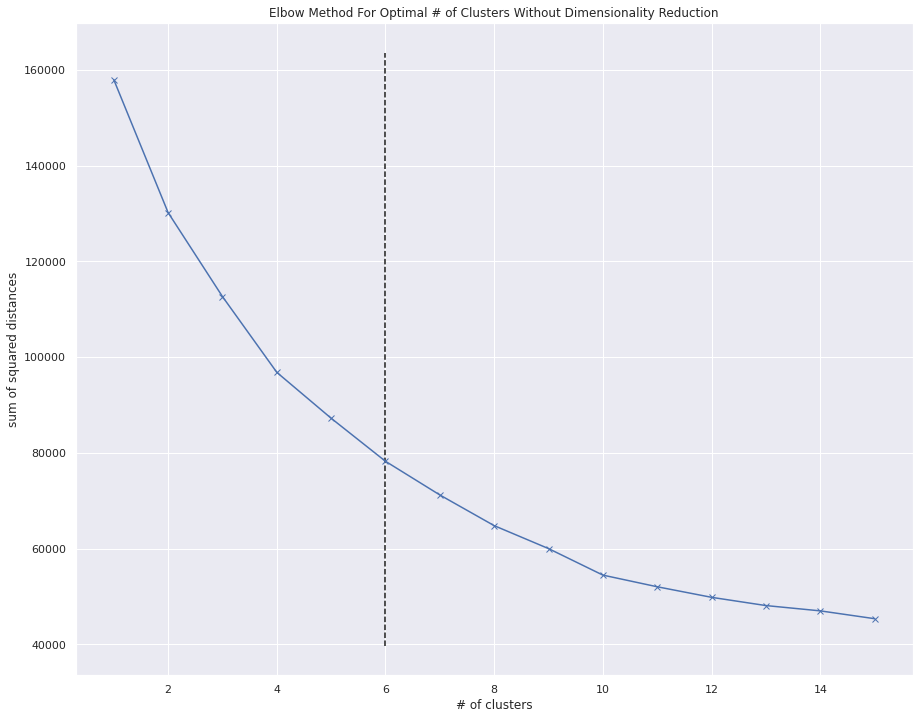

In [14]:
#knee without dimensionality reduction
kn = KneeLocator(range(1, 16), sse_list, curve='convex', direction='decreasing')

plt.plot(range(1, 16), sse_list, 'bx-')
plt.xlabel('# of clusters')
plt.ylabel('sum of squared distances')
plt.title('Elbow Method For Optimal # of Clusters Without Dimensionality Reduction')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

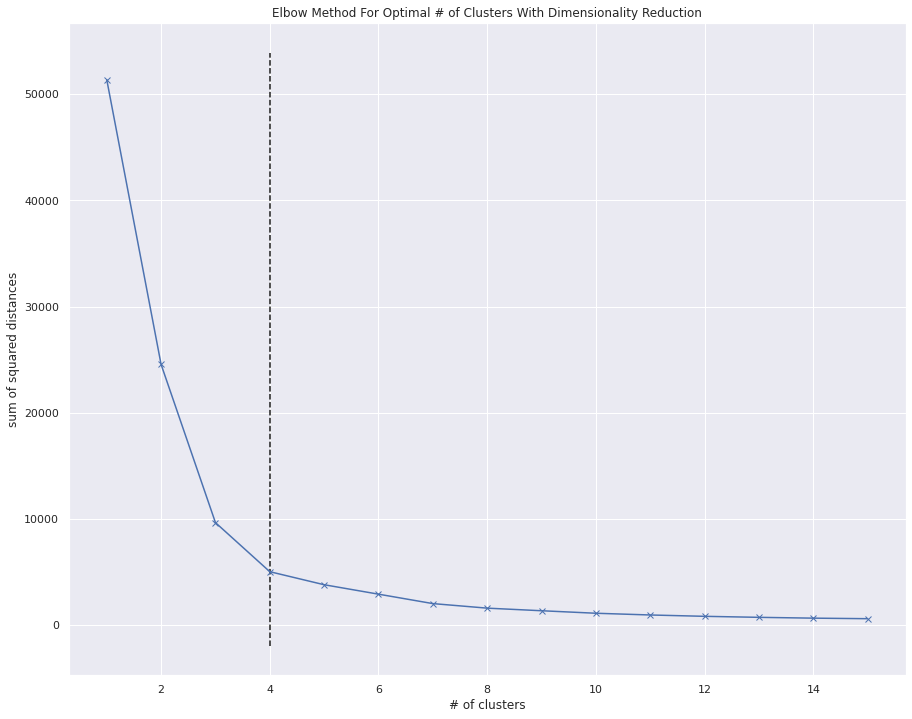

In [15]:
#knee with dimensionality reduction
kn = KneeLocator(range(1, 16), sse_list_reduced, curve='convex', direction='decreasing')

plt.plot(range(1, 16), sse_list_reduced, 'bx-')
plt.xlabel('# of clusters')
plt.ylabel('sum of squared distances')
plt.title('Elbow Method For Optimal # of Clusters With Dimensionality Reduction')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

These graphs show us that the optimal number of clusters with dimesnionality reduction is 4, while without it is 7. We will perform and plot k-means clustering with both of these values.

#3. Perform and Plot K-Means Clustering

**3.1 Plot K-Means clustering with 7 clusters**

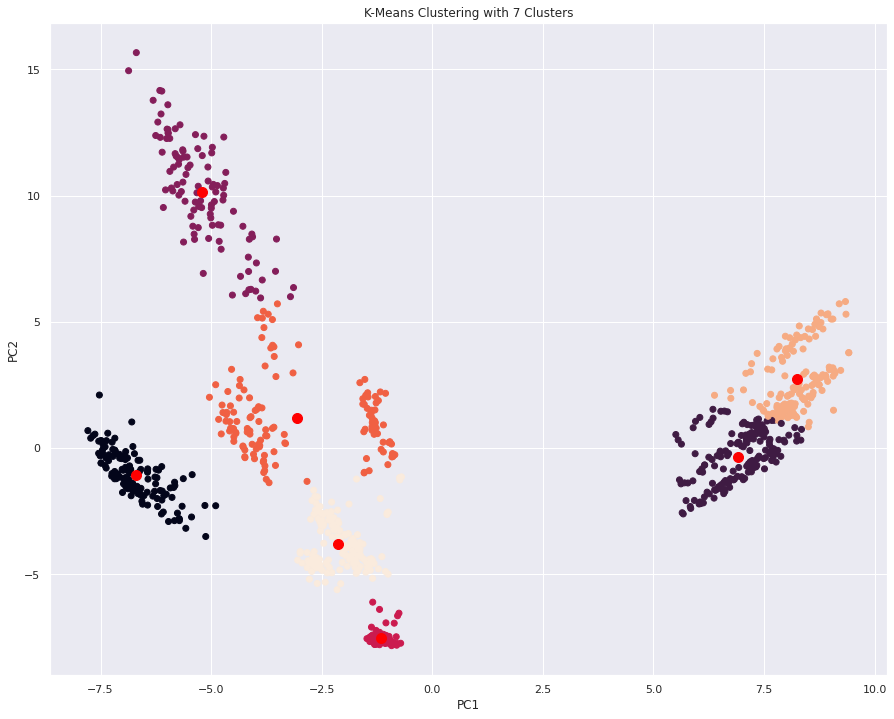

In [16]:
model = KMeans(7)
model.fit(principalComponents)

plt.rcParams['figure.figsize'] = [15, 12]
plt.scatter(principalComponents[:,0],principalComponents[:,1], c=model.labels_)
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=100, color="red") # Show the centres
plt.title('K-Means Clustering with 7 Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

We can see 7 clear clusters with the centers shown in red.

**3.2 Plot K-Mean clustering with 4 clusters**

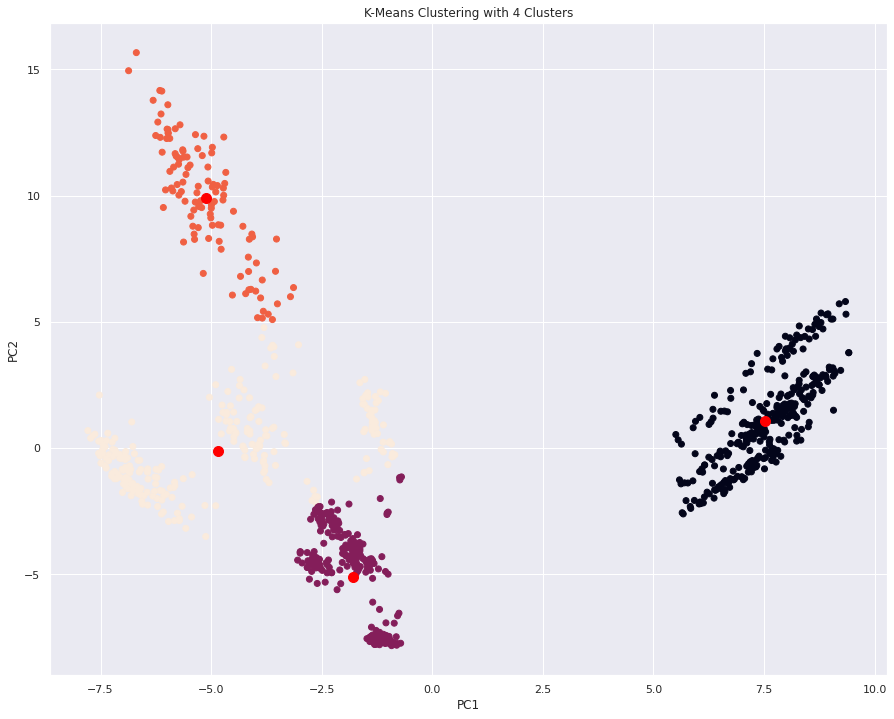

In [17]:
model = KMeans(4)
model.fit(principalComponents)

plt.rcParams['figure.figsize'] = [15, 12]
plt.scatter(principalComponents[:,0],principalComponents[:,1], c=model.labels_)
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=100, color="red") # Show the centres
plt.title('K-Means Clustering with 4 Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

**3.3 Which number of clusters is better?**

4 clusters for k-means clustering is sufficient. 7 clusters becomes excessive and seperates where it seems unecassary.

**3.4 Using cosine distance instead of euclidian distance** 

In order to do cosine distance all you have to do is normalize the data first!

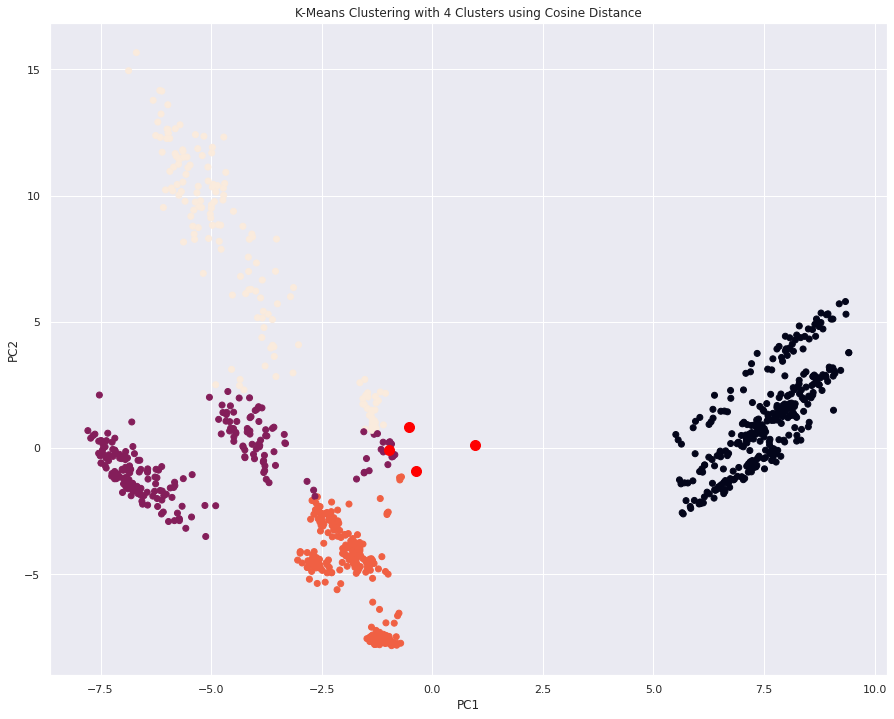

In [23]:
model = KMeans(4)
model.fit(preprocessing.normalize(principalComponents))

plt.rcParams['figure.figsize'] = [15, 12]
plt.scatter(principalComponents[:,0],principalComponents[:,1], c=model.labels_)
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=100, color="red") # Show the centres
plt.title('K-Means Clustering with 4 Clusters using Cosine Distance')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

The overall clustering is similar to euclidian distances but the centeroids are very weirdly off-set into the middle of the entire plot.

#4. Clustering Using Another DBSCAN

**4.1 Finding optimal epsilon value for DBSCAN**

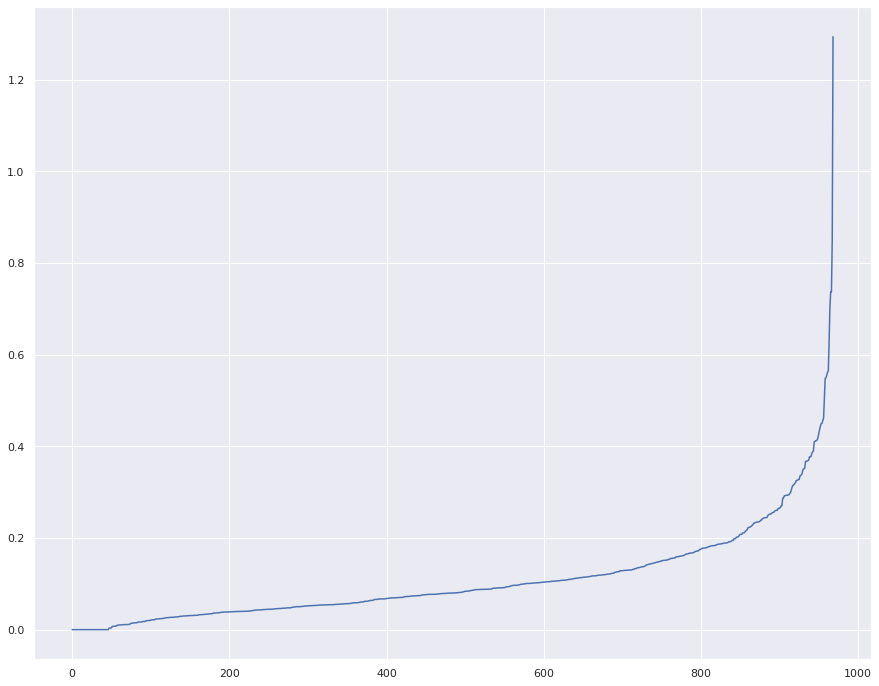

In [18]:
neighbors = NearestNeighbors(n_neighbors=2)
nbrs = neighbors.fit(principalComponents)
distances, indices = nbrs.kneighbors(principalComponents)

distances = np.sort(distances, axis=0)
plt.plot(distances[:,1])

it looks like the optimal epsilon value is about 0.3

**4.2 Clustering and plotting using DBSCAN**

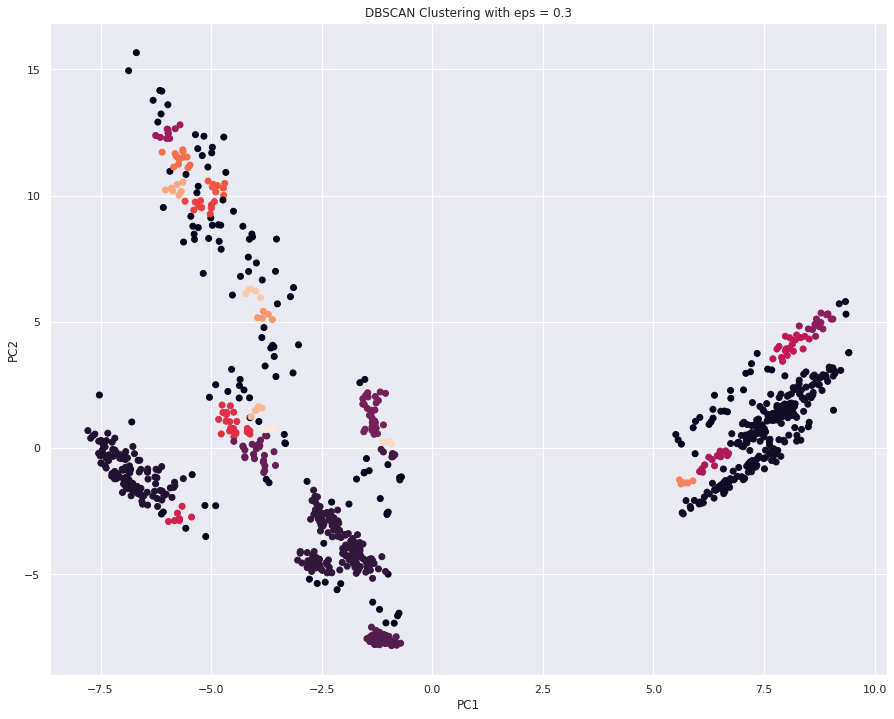

In [21]:
model = DBSCAN(eps=0.3)
model.fit(principalComponents)

plt.scatter(principalComponents[:,0], principalComponents[:,1], c=model.labels_);
plt.title('DBSCAN Clustering with eps = 0.3')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

This graph makes no sense, perhaps we can try a different dimensionality reduction technique such a tSNE and see if we can make more sense of it:

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


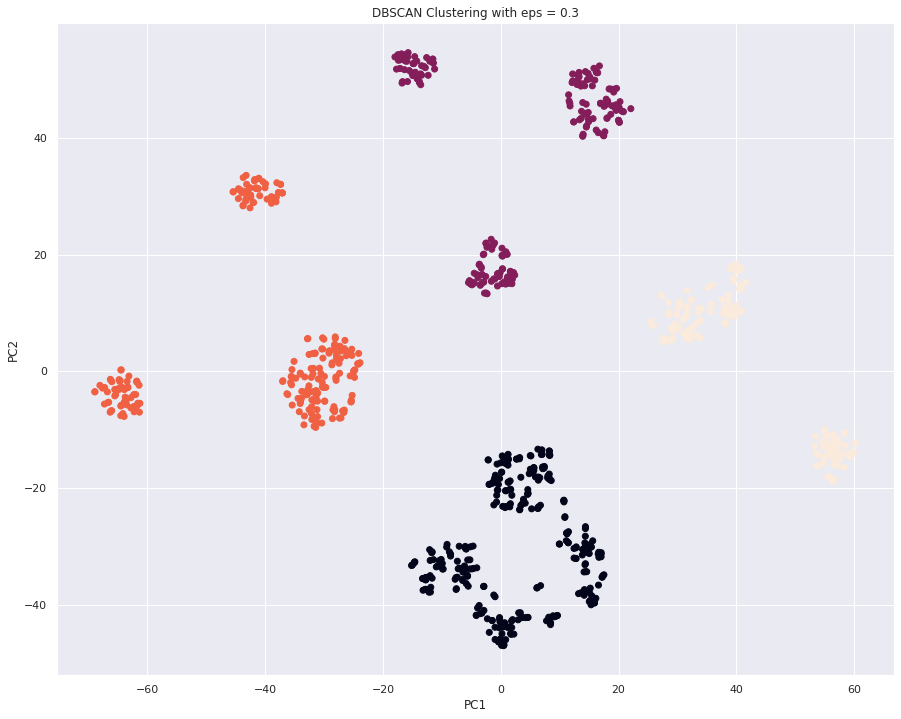

In [24]:
#applying tSNE
tsne = manifold.TSNE(perplexity=30, random_state=42, n_components=2)
tsneComponents = tsne.fit_transform(df)

model2= DBSCAN(eps=0.3)
model.fit(tsneComponents)

plt.scatter(tsneComponents[:,0], tsneComponents[:,1], c=model.labels_);
plt.title('DBSCAN Clustering with eps = 0.3')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Much better! We can see the clusters much clearer here.

# 5. Conclusions

K-means clustering works well for this data with the optimal number of clusters being 4 (as determined by the elbow method). We could also see this was true when trying 7 clusters and seeing excessive seperation in labelling despite not as much distance between the data. Using cosine distance as opposed to euclidian yielded similar clustering results but had the centeroid points skewed towered the middle of all the data. This was strange to me and quite honestly I am not 100% sure how to explain it.

DBSCAN clustering also worked well (although I would say K-means is preferred for this data); however could not be visualized with PCA. Instead you had to apply tSNE to make it readable. This is interesting since tSNE is especially good for data that cannot be seperated in a straight line. This makes me think that with DBSCAN the data is more intertwined than PCA can handle. In addition DBSCAN is supposed to take find noise in the data- but it seems like there was no noise. This is one of the reasons I think k-means is more useful for this data than DBSCAN, since there is no need to find and reduce noise.